In [8]:
import sys
sys.path.append('../')
from PINN_Base.util import rmse, rel_error
from PINN_Survey.problems.burgers.data.load import load_burgers_bounds
from PINN_Survey.problems.burgers.v1 import Burgers, Burgers_Sphere_Mesh
import numpy as np
import matplotlib.pyplot as plt

First, we load the burgers data and select boundary and differential points

In [2]:
X_true, U_true, X_bounds, U_bounds, [x,t,u] = load_burgers_bounds()

X = np.vstack(X_bounds)
U = np.vstack(U_bounds)

idx = np.random.choice( list(range(X_true.shape[0])), size=10000 )

X_df = X_true[idx,:]

lower_bound = np.min(X_true,axis=0)
upper_bound = np.max(X_true,axis=0)

Burgers problem from the appendix of (Raissi, 2018). At t=0, the equation is $sin(x)$. A shockwave slowly develops as t increases. 

Text(0.5, 1.0, 'Burgers (Shockwave)')

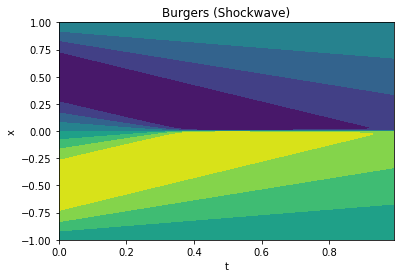

In [7]:
plt.tricontourf(X_true[:,1],X_true[:,0], U_true[:,0])
plt.xlabel("t")
plt.ylabel("x")
plt.title("Burgers (Shockwave)")

Create a base (MLP) model for burgers and train using BFGS

In [12]:
nu = .01/np.pi
model = Burgers(nu, lower_bound,upper_bound, [2,20,20,20,20,20,20,20,20,1])
model.train_BFGS(X,U,X_df,True)

U_hat = model.predict(X_true)

print(f"RMSE: {rmse(U_true, U_hat):.2E}")
print(f"Relative Error: {rel_error(U_true, U_hat):.2E}", )

RMSE: 8.05E-04
Relative Error: 1.31E-03


Take a look at the activation functions for the final layer.

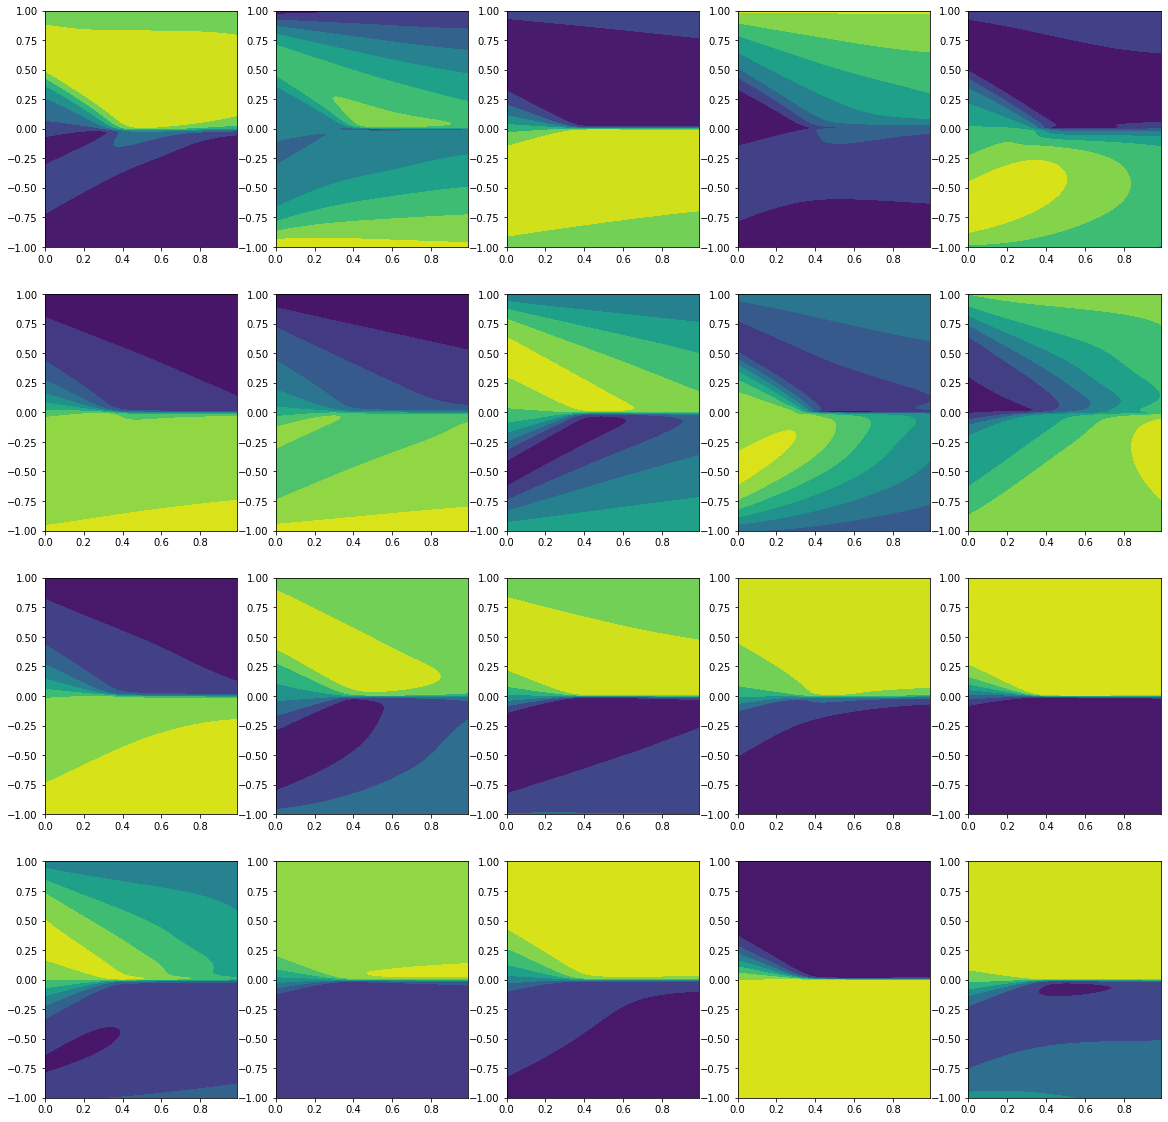

In [15]:
activations = model.get_activations(X_true, layer=-1)
fig, axes = plt.subplots(4,5, figsize=(20,20))

for row in range(4):
    for col in range(5):
        axes[row,col].tricontourf(X_true[:,1], X_true[:,0], activations[:,row*5 + col])

Train using the shphere-mesh architecture

In [16]:
model = Burgers_Sphere_Mesh(nu, lower_bound,upper_bound,[2,20,20,1],[2,20,20,20,20])
model.train_BFGS(X,U,X_df,True)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000003
  Number of iterations: 6238
  Number of functions evaluations: 6717


Notice the resulting relative error is almost an order of magnitude smaller.

In [17]:
U_hat = model.predict(X_true)

print(f"RMSE: {rmse(U_true, U_hat):.2E}")
print(f"Relative Error: {rel_error(U_true, U_hat):.2E}", )

RMSE: 4.03E-04
Relative Error: 6.55E-04


These mesh functions have a natural scale, so we plot them on the range 0,1.

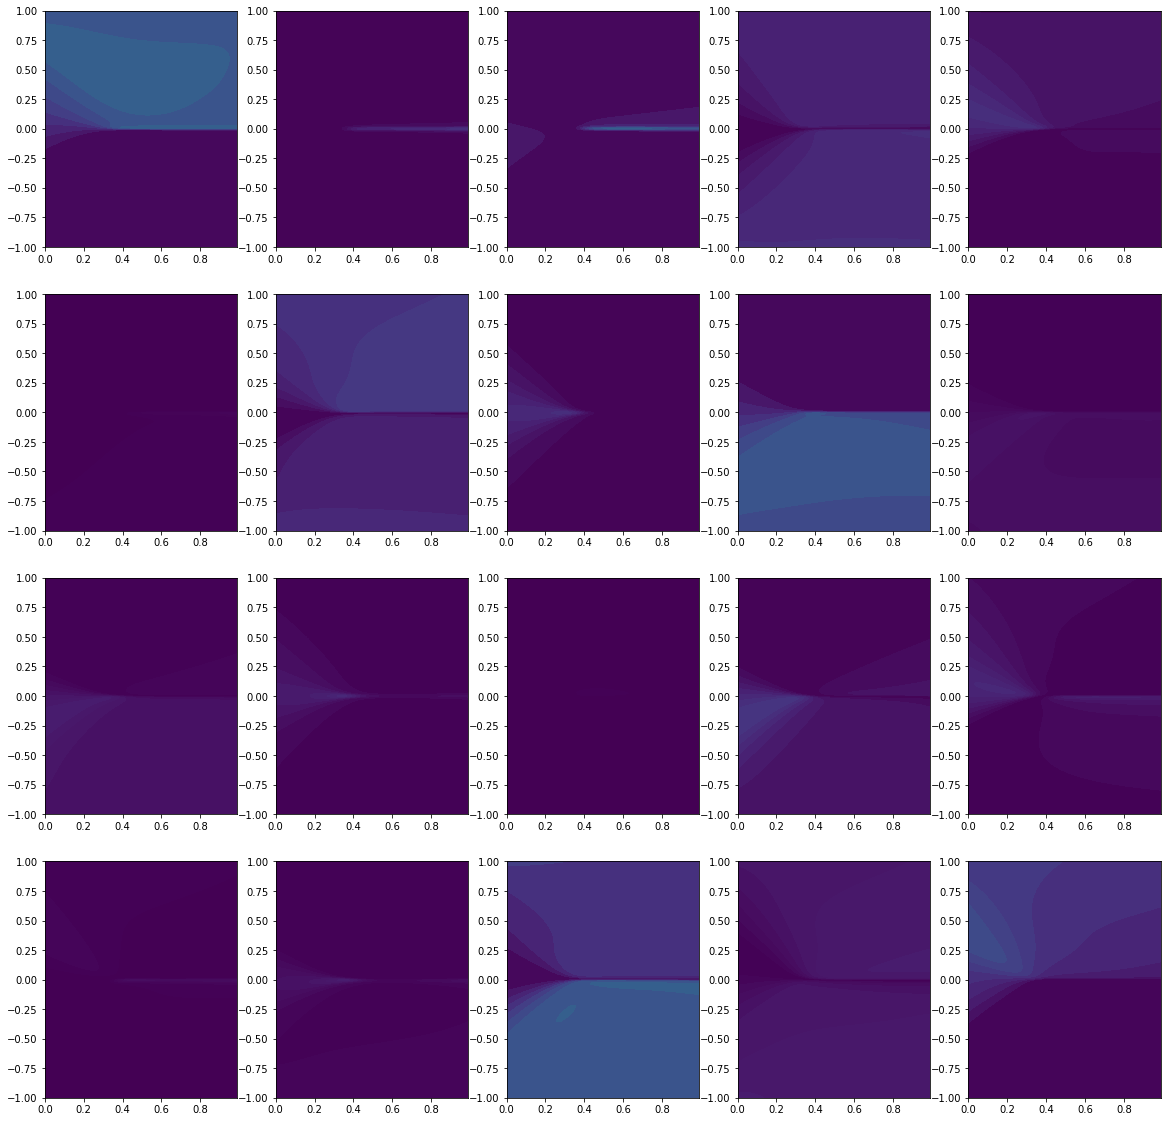

In [18]:
mesh_functions = model.get_probs(X_true)

fig, axes = plt.subplots(4,5, figsize=(20,20))

for row in range(4):
    for col in range(5):
        axes[row,col].tricontourf(X_true[:,1], X_true[:,0], mesh_functions[:,row*5 + col],vmin=0,vmax=1)